# Introduction

This notebook describes various statistical and visual analyses for the tumor population described by `MyModel.py`.

## Last changes (12/05/2018):

* added new version of `reconstruct_mutational_timeline()` that uses dimensionless time

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from ThesisScripts.MyModel import Population, Clone

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#matplotlib preamble, taken from http://blog.juliusschulz.de/blog/ultimate-ipython-notebook
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 14, 7
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

# Reference simulation

In [2]:
# Test cell: Reference population

# set seed to get same result for each test simulation
np.random.seed(123)

l = 10**6
q = 10**(-3)
testRef = Population(l, q, mutfactor=1, death_frac=0.3)
testRef.simulate()
print("testRefotal population size:", testRef.size)
print("Generations:", testRef.gen)
print()
print("Start clone size:", testRef.start_clone.size)
print("Total number of mutations:", sum(testRef.mut_vec))
print("Number of subclones:", len(testRef.clones[1:]))
print("Total size of subclones:", sum([x.size for x in testRef.clones[1:]]))
print("Dead clones:", len([x for x in testRef.clones if x.size == 0]))
print()

testRefotal population size: 1668674
Generations: 27

Start clone size: 1655654
Total number of mutations: 2375
Number of subclones: 2375
Total size of subclones: 13020
Dead clones: 210



# Summary statistics

In [3]:
def final_data(pop):
    '''Generates a dataframe containing the final properties of every clone in population pop. 
        Each row represents a separate clone, each column is a different property'''

    data_keys = ["Clone ID", "Birthday", "q", "Final size", "Family size", 
                 "Allele frequency", "Mutations", "Children", "Weight", "RGB color"]
    clone_id = []
    birthday = []
    mutrate = []
    final_size = []
    family_size = []
    af = []
    num_acc_mutations = []
    num_children = []
    weight = []
    rgb_color = []

    for clone in pop.clones:
        clone_id.append(clone.ID)
        birthday.append(clone.birthday)
        mutrate.append(clone.mutrate)
        final_size.append(clone.size)
        fam_size = clone.get_family_size()
        family_size.append(fam_size)
        af.append(fam_size / pop.size)
        num_acc_mutations.append(clone.num_mutations)
        num_children.append(len(clone.subclones))
        weight.append(clone.weight)
        rgb_color.append(clone.rgb_color)
    
    data_values = [clone_id, birthday, mutrate, final_size, family_size, af, 
                   num_acc_mutations, num_children, weight, rgb_color]
    zipped = list(zip(data_keys, data_values))
    data = dict(zipped)
    df = pd.DataFrame(data)
    df.set_index('Clone ID', inplace=True)  # setting Clone IDs as index
    df = df[['Birthday', 'q', 'Final size', 'Family size', 'Allele frequency', 'Mutations', 
             'Children', 'Weight', 'RGB color']]   # rearranging order of columns
    
    return df

In [4]:
test_df = final_data(testRef)
print(test_df.head(10))

          Birthday      q  Final size  Family size  Allele frequency  \
Clone ID                                                               
A                0  0.001     1655654      1668674          1.000000   
A.0              7  0.001           0            0          0.000000   
A.1             15  0.001        2275         2275          0.001363   
A.2             15  0.001         964          969          0.000581   
A.3             16  0.001           0            0          0.000000   
A.4             17  0.001         102          102          0.000061   
A.5             17  0.001           0            0          0.000000   
A.6             17  0.001         107          107          0.000064   
A.7             17  0.001           0            0          0.000000   
A.8             17  0.001          17           17          0.000010   

          Mutations  Children  Weight        RGB color  
Clone ID                                                
A                 0  

# Accumulated number of mutations

## Evolution over time

In [7]:
def num_mutations_evolution(population):
    '''Return DataFrame containing the evolution of clone.num_mutations over the generations and a figure 
        containing the corresponding chart'''
    dic = {}   # temporary dictionary to store data 
    
    for clone in population.clones:
        n = clone.num_mutations
        if n == 1:
            key = "%i mutation" %(n)
        else:
            key = "%i mutations" %(n)
        
        if key not in dic.keys():
            dic[key] = sum(x.size_vec for x in population.clones if x.num_mutations == n)
        
    df = pd.DataFrame(dic)
    df = df.rename_axis("generation")
    
    # creating the evolution chart
    fig = plt.figure()
    ax = df.plot(colormap='Accent', style='d--', xticks=df.index)
    ax.set_xlabel('Generation')
    ax.set_ylabel('Cell count')
    ax.set_yscale('log')

    return df, fig

            0 mutations  1 mutation  2 mutations
generation                                      
0                     1           0            0
1                     2           0            0
2                     3           0            0
3                     5           0            0
4                     8           0            0


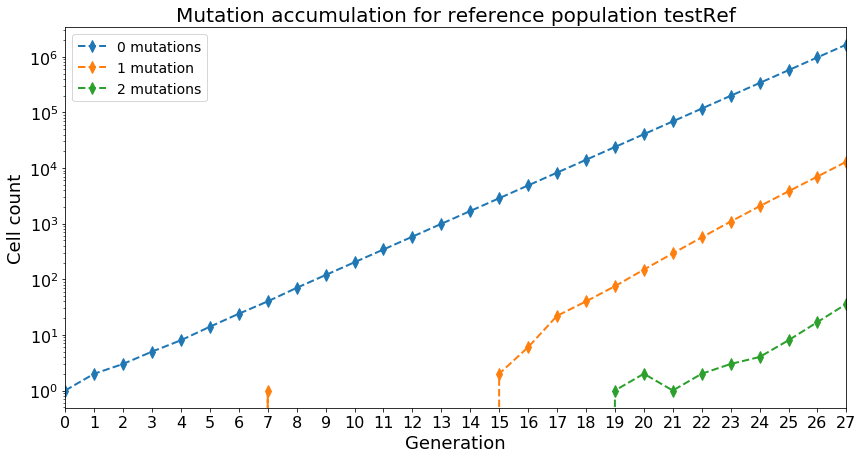

In [8]:
d, d_fig = num_mutations_evolution(testRef)
print(d.head())
plt.title('Mutation accumulation for reference population testRef')
plt.show()

## Distribution

In [21]:
def num_mutations_distribution(data, det_lim=1):
    '''Returns a dataframe containing the number of mutations and the total number of cells carrying that
        number of mutations
        Uses a DataFrame in the format given by final_data() as input'''
    
    data = data.loc[data['Final size'] >= det_lim].iloc[1:]  # filter out clones with size < det_lim
    max_n = data['Mutations'].max()  # maximal number of mutations in one clone
    
    dic = {}  # initialize empty dictionary to store data
    dic["# mutations"] = []
    dic["Cell count"] = []
    
    for n in range(1, max_n+1):
        size = np.sum(data[data['Mutations'] == n]['Final size'])
        dic["# mutations"].append(n)
        dic["Cell count"].append(size)
        
    df = pd.DataFrame(dic)
    df.set_index("# mutations", inplace=True)
    return df

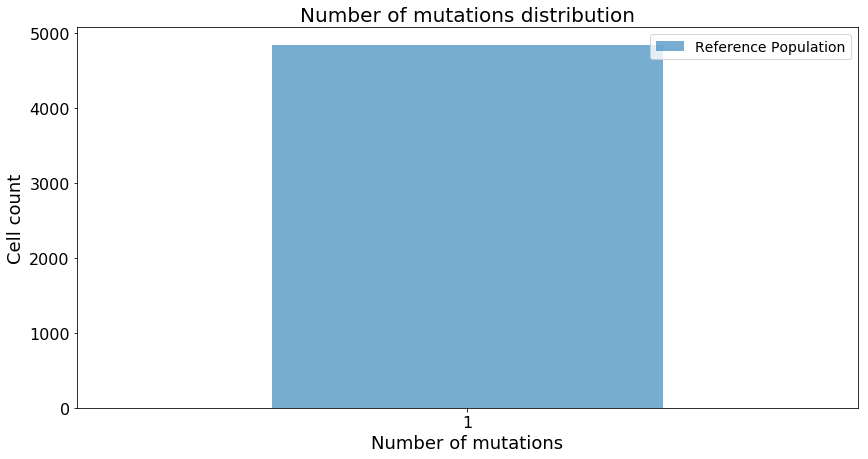

In [22]:
# test
nmd = num_mutations_distribution(test_df, det_lim=100)
nmd.columns = ["Reference Population"]
nmd.plot(kind='bar', logy=False, legend=True, rot=0, alpha=0.6)
plt.ylabel("Cell count")
plt.xlabel("Number of mutations")
plt.title("Number of mutations distribution")
plt.show()

## Average number of mutations per clone

In [11]:
def avg_num_mutations(num_mut_distr):
    '''Returns the average number of mutations per clone, weighted by the clone size.
        Takes a DataFrame of the format given by num_mutations_distribution as input.'''
    nmd = num_mut_distr
    w_sizes = []
    for i in range(nmd.index.min(), nmd.index.max()+1):
        weighted_size = i * nmd.loc[i]
        w_sizes.append(weighted_size)
        
    w_sizes = np.array(w_sizes)
    avg = np.sum(w_sizes) / np.sum(nmd.values)
    
    return avg

In [12]:
avg_num_mutations(nmd)

1.0

# Allele frequency spectrum

In [15]:
testRef_af = test_df.loc[test_df['Family size'] >= 10]["Allele frequency"]
testRef_af.head()

Clone ID
A      1.000000
A.1    0.001363
A.2    0.000581
A.4    0.000061
A.6    0.000064
Name: Allele frequency, dtype: float64

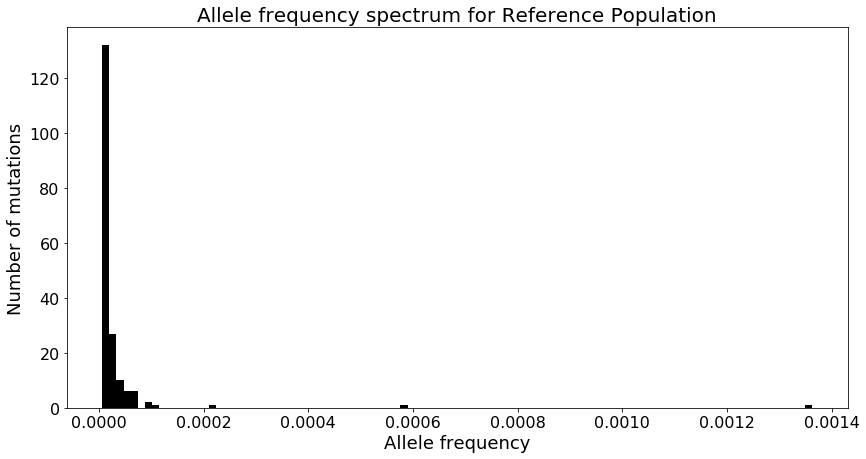

In [16]:
testRef_af.iloc[1:].plot(kind='hist', grid=False, logy=False, bins=100, color='k')
plt.ylabel('Number of mutations')
plt.xlabel('Allele frequency')
plt.title('Allele frequency spectrum for Reference Population')
plt.show()

## Cumulative number of mutations per frequency and fitting to the power-law distribution

According to Williams *et al.* (2016), the number of mutations is inversely related to the allelic frequency ($M(f) \sim \frac{1}{f}$) when the tumor grows under neutral evolution conditions. This hypothesis is tested for the model presented here.

The cumulative number of mutations per inverse allelic frequency is calculated based on the allele frequency spectrum defined in the previous section. Each frequency represents a distinct mutation (see AF Dataframe), these are inversed and then sorted in increasing order. The unique values of $1/f$ are determined and the number of times they appear is counted. When taking the cumulative sum of these counts, one obtains the cumulative number of mutations $M(f)$ per allelic frequency. A linear fit is then calculated between $M(f)$ and $1/f$ to test the hypothesis model. If the model is obeyed, a good fit should be found.

In [19]:
def fit_cumulative_mutations(data, det_lim=1, plot=False):
    '''
    Calculates the cumulative number of mutations per allelic frequency (M(f)) and plots it in function of 1/f
        and then fits the data using linear regression to test whether M(f) is linear with 1/f

    Extracts allele frequencies from a final_data() type of dataframe
    Filters out clones with family size < detection limit (det_lim, default 1)

    If plot == True, returns a figure containing the plot (default: False)

    Returns
    -------
        * raw_data: raw data consisting of a DataFrame with 1/f and corresponding Cumulative count
        * r_value: R2 value of the linear regression between the cumulative count and 1/f
        * fig (if plot==True): plot of M(f) and the linear regression fit
    '''
    # filter out start clone and clones with size < det_lim
    data = data.loc[data['Family size'] >= det_lim].iloc[1:]
    f = data["Allele frequency"].values   # don't take start clone into account
    f_inv = 1/f
    f_inv_sorted = np.sort(f_inv)
    u, counts = np.unique(f_inv_sorted, return_counts=True)
    cf = np.cumsum(counts)

    # create DataFrame to return the raw data that was used to do the fitting
    #raw_data = pd.DataFrame()
    #raw_data["f (uniques)"] = 1/u
    #raw_data["1/f"] = u
    #raw_data["Cumulative count"] = cf

    # calculate the linear regression fit between cf and u
    slope, intercept, r_value, p_value, std_err = stats.linregress(u, cf)
    r = round(r_value, 3)


    if plot:
        #coordinates to display R2 text on graph
        rx = 0.8*max(u)
        ry = 1.2*(intercept + slope*rx)
        
        fig = plt.figure()
        ax = plt.plot(u, cf, marker='o', markersize=5, lw=0, color='black')
        plt.plot(u, intercept + slope*u, 'r')
        plt.title("Cumulative number of mutations per allelic frequency")
        plt.xlabel("Inverse allelic frequency 1/f")
        plt.ylabel("Cumulative number of mutations M(f)")
        new_ticks = np.linspace(min(u), max(u), num=5)
        xticklabels = ['1/%f' %(i) for i in 1/new_ticks]
        plt.xticks(new_ticks, xticklabels)
        plt.text(rx, ry, r'$R^2=$ %s'%(r))

    return r_value


R^2 = 0.999071682051


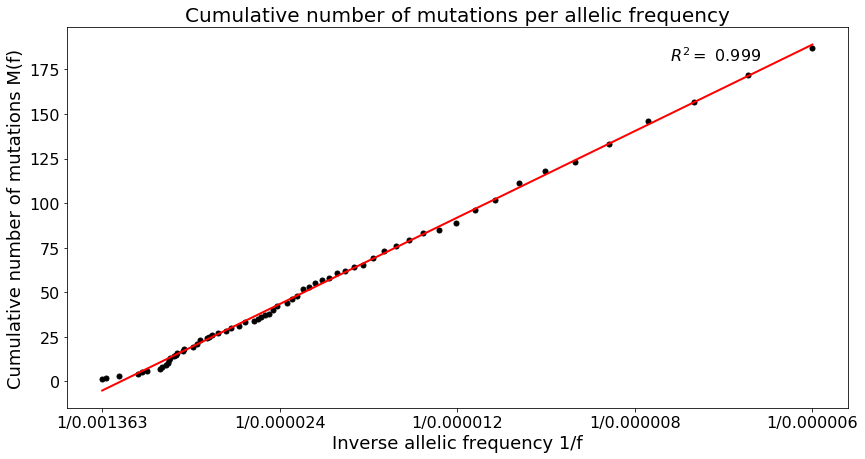

In [20]:
fit_testRef_af_r_value = fit_cumulative_mutations(test_df, det_lim=10, plot=True)
print("\nR^2 =", fit_testRef_af_r_value)
plt.show()

## Heterogeneity: Simpson's diversity index

Measure for tumor heterogeneity. Based on Ling *et al.* (2015).

Formula:

$$ H = 1 - \sum_{i}\left(\frac{n_i}{N}\right)^2 $$
with $n_i$ the individual size of clone $i$ and $N$ the total size of the mutants (subclones).

In [17]:
def heterogeneity(data, det_lim=1):
    '''Calculates the heterogeneity of a population, based on Simpson's diversity index.
        Option to set a detection limit (det_lim, default 1)'''

    data = data.loc[data["Final size"] >= det_lim].iloc[1:]
    sizes = data["Final size"].values # individual detected clone sizes
    N = np.sum(sizes)  # total size of detected clones
    h = 1 - np.sum((sizes/N)**2)
    return h

In [18]:
heterogeneity(test_df, det_lim=10)

0.92292609234735101

## Mutational timeline

Recreating Figure 4 of Williams *et al.* (2016) paper for simualated populations.

In [25]:
def reconstruct_mutational_timeline(data, alpha, det_lim=1):
    '''Reconstructs mutational history of the population from allele frequencies.
        
        Arguments: 
            * data : final_data() dataframe format
            * alpha : death fraction of the analyzed population
            * det_lim : detection limit used to filter out small clones
            
        Returns 3 arrays:
            * reconstructed timepoints at which mutations occurred
            * reconstructed population sizes
            * errors: deviation of the reconstructed timepoint from the real one, absolute value'''

    clones = data.loc[data["Final size"] >= det_lim].iloc[1:]
    
    rec_birthdays = []
    rec_popsizes = []
    errors = []

    for index, clone in clones.iterrows():
        af = clone["Allele frequency"]
        rec_N = 1/af      # reconstructing population size from allele frequency of clone   
        # calculating birthday of clone from reconstructed population size (according to N(t) = (2-alpha)**t)
        rec_t = np.log(rec_N)/np.log(2-alpha)
        rec_popsizes.append(rec_N)
        rec_birthdays.append(rec_t)
        # calculating the error on the reconstructed birthday
        real_t = clone["Birthday"]
        error = np.abs(real_t - rec_t)
        errors.append(error)
    
    rec_popsizes = np.array(rec_popsizes)
    rec_birthdays = np.array(rec_birthdays)
    errors = np.array(errors)
    
    return rec_birthdays, rec_popsizes, errors

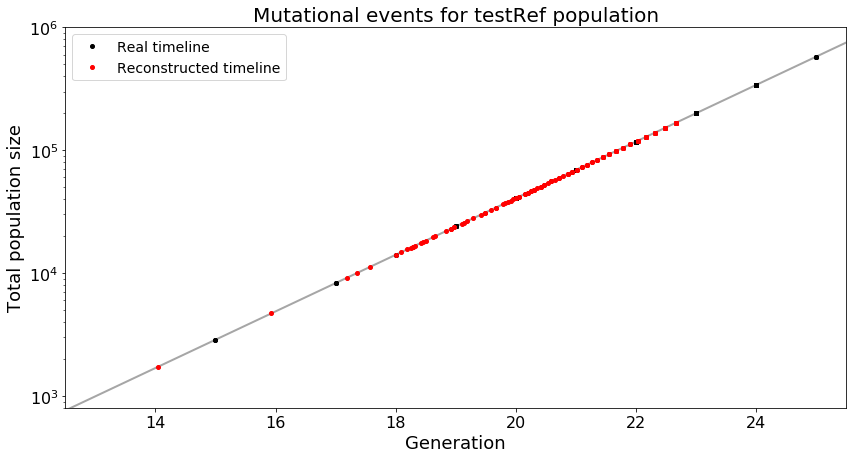

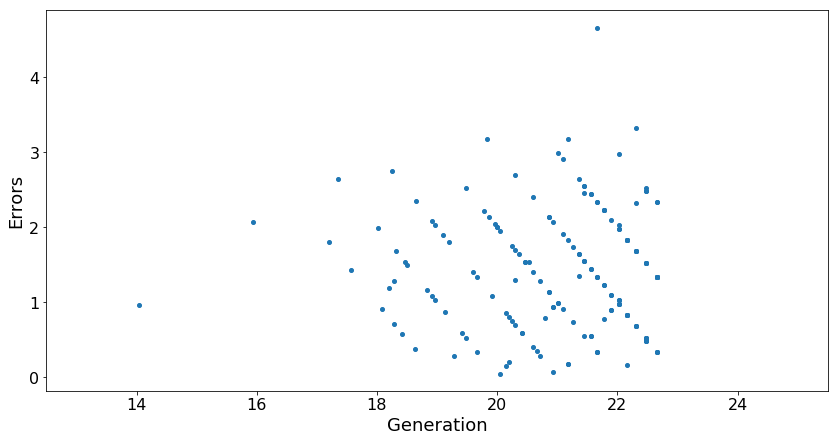

In [26]:
mutations = test_df.loc[test_df['Family size'] >= 10].iloc[1:]
real_t = mutations['Birthday'].values
real_popsizes = list(testRef.size_vec[i] for i in real_t)

alpha = testRef.death_frac
rec_t, rec_popsizes, errors = reconstruct_mutational_timeline(test_df, alpha, det_lim=10)

plt.plot(testRef.size_vec, color='gray', alpha=0.7);
plt.plot(real_t, real_popsizes, marker='.', color='k', linestyle='none', label='Real timeline');
plt.plot(rec_t, rec_popsizes, marker='.', color='r', linestyle='none', label='Reconstructed timeline')
plt.xlabel('Generation');
plt.ylabel('Total population size');
plt.legend(loc="upper left");
plt.title('Mutational events for testRef population');
plt.xlim(12.5, 25.5);
plt.ylim(800, 10**6);
plt.yscale('log');
plt.show()

plt.plot(rec_t, errors, marker='.', linestyle='none');
plt.xlabel('Generation');
plt.ylabel('Errors');
plt.xlim(12.5, 25.5);
plt.show()

## Reconstructing mutational timeline with dimensionless doubling times

Doubling time:

$$ t_D = \frac{\ln(2)}{\gamma} $$

Dimensionless time:

$$ T = t / t_D = t \cdot \frac{\gamma}{\ln(2)} $$
$$ \gamma = \ln(2 - \alpha) $$
with $\alpha$ = death fraction

Growth equation in units of dimensionless time:

$$ N(T) = e^{\ln(2)T} $$

Reconstructed mutational events expressed in number of population size doublings:

$$ T_i = \frac{1/f}{\ln(2)} $$

with $f$ the allele frequency of the mutation.


In [8]:
def reconstruct_mutational_timeline_dimensionless(data, alpha, det_lim=1):
    '''Reconstructs mutational history of the population from allele frequencies, 
        in units of population size doublings.
        
        Arguments: 
            * data : final_data() dataframe format
            * alpha : death fraction of the analyzed population
            * det_lim : detection limit used to filter out small clones
            
        Returns 3 arrays:
            * reconstructed timepoints at which mutations occurred
            * reconstructed population sizes
            * errors: deviation of the reconstructed timepoint from the real one, absolute value'''

    clones = data.loc[data["Final size"] >= det_lim].iloc[1:]
    
    rec_birthdays = []
    rec_popsizes = []
    errors = []

    for index, clone in clones.iterrows():
        af = clone["Allele frequency"]
        
        # reconstructing population size from allele frequency of clone  
        rec_N = 1/af
        
        # calculating birthday of clone from reconstructed population size (according to N(T) = 2**T)
        # in units of number of population size doublings
        rec_T = np.log(rec_N)/np.log(2)
        rec_popsizes.append(rec_N)
        rec_birthdays.append(rec_T)
        
        # calculating the error on the reconstructed birthday
        # real birthday has to be converted to dimensionless time (T = t/tD = t*y/ln(2))
        real_T = clone["Birthday"]
        real_T = real_T*np.log(2-alpha)/np.log(2)
        error = np.abs(real_T - rec_T)
        errors.append(error)
    
    rec_popsizes = np.array(rec_popsizes)
    rec_birthdays = np.array(rec_birthdays)
    errors = np.array(errors)
    
    return rec_birthdays, rec_popsizes, errors

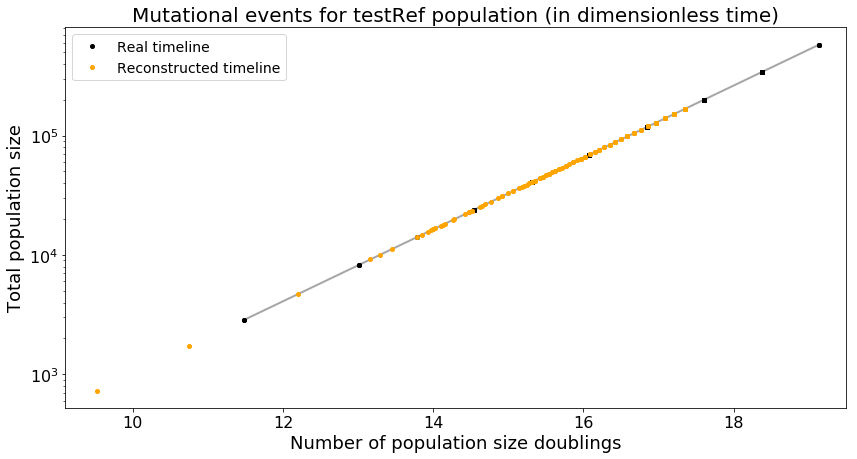

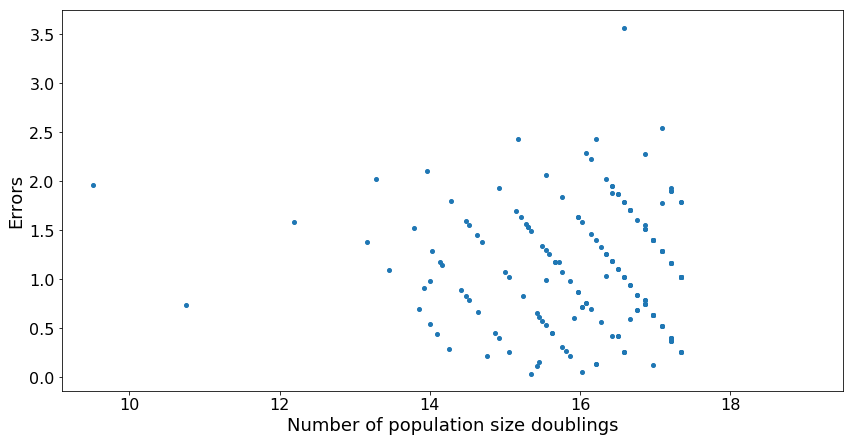

In [15]:
alpha = testRef.death_frac

mutations = test_df.loc[test_df['Family size'] >= 10].iloc[1:]
real_t = mutations['Birthday'].values
real_T = real_t*np.log(2-alpha)/np.log(2)
real_popsizes = list(testRef.size_vec[i] for i in real_t)

rec_T, rec_popsizes, errors = reconstruct_mutational_timeline_dimensionless(test_df, alpha, det_lim=10)

plt.plot(real_T, real_popsizes, color='gray', alpha=0.7);
plt.plot(real_T, real_popsizes, marker='.', color='k', linestyle='none', label='Real timeline');
plt.plot(rec_T, rec_popsizes, marker='.', color='orange', linestyle='none', label='Reconstructed timeline')
plt.xlabel('Number of population size doublings');
plt.ylabel('Total population size');
plt.legend(loc="upper left");
plt.title('Mutational events for testRef population (in dimensionless time)');
plt.yscale('log');
plt.xlim(9.1, 19.5);
plt.show()

plt.plot(rec_T, errors, marker='.', linestyle='none');
plt.xlabel('Number of population size doublings');
plt.ylabel('Errors');
plt.xlim(9.1, 19.5);
plt.show()

In [18]:
np.log(1668674)/np.log(2)

20.670270699865213